           Time      Ampl
0        -0.001 -0.000166
1        -0.001  0.000332
2        -0.001 -0.000166
3        -0.001  0.000000
4        -0.001 -0.000166
...         ...       ...
9999997   0.001 -0.000166
9999998   0.001 -0.000166
9999999   0.001  0.000166
10000000  0.001 -0.000498
10000001  0.001  0.000166

[10000002 rows x 2 columns]
           Time      Ampl
0        -0.001 -0.000332
1        -0.001 -0.000166
2        -0.001 -0.000166
3        -0.001  0.000000
4        -0.001  0.000166
...         ...       ...
9999997   0.001  0.000166
9999998   0.001 -0.000332
9999999   0.001  0.000332
10000000  0.001  0.000332
10000001  0.001  0.000498

[10000002 rows x 2 columns]
           Time      Ampl
0        -0.001  0.000906
1        -0.001 -0.002414
2        -0.001  0.004227
3        -0.001 -0.009056
4        -0.001  0.000906
...         ...       ...
9999996   0.001  0.000906
9999997   0.001 -0.005735
9999998   0.001 -0.005735
9999999   0.001 -0.005735
10000000  0.001 -0.005735

[1000

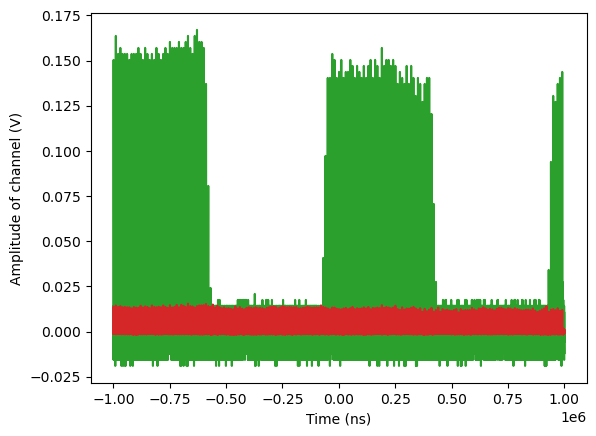

In [2]:
#Import data with pulsed signal field 

#In this python script we aim to extract the data from a csv file from the 1 GHz oscilloscope for the
#interferometer traces using a pulsed signal and a pulsed control field 

import cmath as cmath
import numpy as np
import scipy as sp
import csv
from scipy import integrate
from scipy.signal import chirp, find_peaks, peak_widths, find_peaks_cwt
import pandas as pd
import matplotlib.pyplot as plt 
from math import pi
from scipy import optimize
from scipy import ndimage

SampleRate = 5*10**9

#the signal average power in the title needs the propagation loss taken into account 

#import first detector trace

dataCH1= pd.read_csv(r"CH1.csv", sep=',', encoding='latin-1', skiprows=4 )
print(dataCH1)  #importing the data into a dataframe using pandas from a csv file

tCH1 = dataCH1["Time"]  #setting each column as a variable
yCH1 = dataCH1["Ampl"]

plt.plot(tCH1*10**9, yCH1)  #plotting the data from the dataframe for detector channel 1 

#import second detector trace

dataCH3= pd.read_csv(r"CH3.csv", sep=',', encoding='latin-1', skiprows=4 )
print(dataCH3)  #i~mporting the data into a dataframe using pandas from a csv file

tCH3 = dataCH3["Time"]  #setting each column as a variable
yCH3 = dataCH3["Ampl"]

plt.plot(tCH3*10**9, yCH3)  #plotting the data from the dataframe for detector channel 3 

#import control trace

dataCH4= pd.read_csv(r"CH4.csv", sep=',', encoding='latin-1', skiprows=4 )
print(dataCH4)  #importing the data into a dataframe using pandas from a csv file

#CH4 in this script is the control, CH1 and CH3 are for the detector traces 

tCH4 = dataCH4["Time"]  #setting each column as a variable
yCH4 = dataCH4["Ampl"]

plt.plot(tCH4*10**9, yCH4)  #plotting the data from the dataframe for control detector

#Calculating the sum of the two detector channels
tCHSum1and3 = tCH1 
toriginal = tCH1 

yCHSum1and3 =np.add(yCH1,yCH3)

plt.plot(tCHSum1and3*10**9, yCHSum1and3)  #plotting the data from the dataframe for the sum of detector 1 and 3 

plt.xlabel("Time (ns)")

plt.ylabel("Amplitude of channel (V)")
plt.savefig('Oscilloscope data from pulsed interferometer being analysed.png', dpi=400)



[      0       1       2 ... 4639997 4639998 4639999] deletestart
[ 9640001.  9640002.  9640003. ...  9999999. 10000000. 10000001.] deleteend
[       0        1        2 ...  9999999 10000000 10000001] deleteboth
4640000
10000002


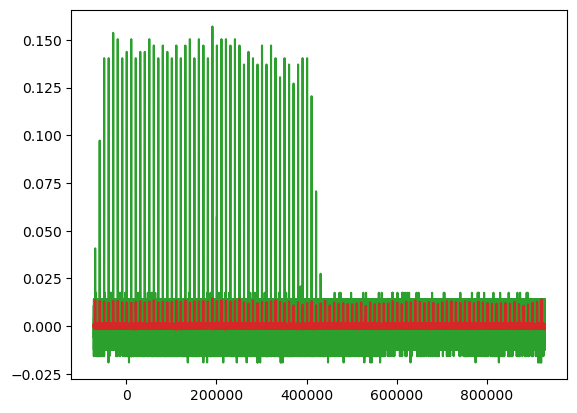

In [3]:
#we next want to get our data in the form of one section of the control on, and one section of the control off

#indices to delete depends on the initial form of the data. The desired form of the data is 50 signal pulses with the control on, followed by 50 with the control off

deletestart = np.arange(4640000) #set range of start indices to delete
deleteend = len(tCH1)+np.linspace(-360000,0,360001)-1 #set range of end indices to delete

print(deletestart,'deletestart')
print(deleteend,'deleteend')
deleteboth = np.concatenate((deletestart, deleteend)) #join the start and end indices arrays into one array 
deleteboth = deleteboth.astype(int) #convert to integer values 
print(deleteboth,'deleteboth')

print(len(deletestart))
print(len(tCH1))

#convert data arrays to numpy arrays

tCH1 = np.asarray(tCH1)
yCH1 = np.asarray(yCH1)

tCH3 = np.asarray(tCH3)
yCH3 = np.asarray(yCH3)

tCH4 = np.asarray(tCH4)
yCH4 = np.asarray(yCH4)

tCHSum1and3 = np.asarray(tCHSum1and3) 
yCHSum1and3 = np.asarray(yCHSum1and3)

#delete the start and end data ranges 

tCH11 = np.delete(tCH1,deleteboth) 
yCH11 = np.delete(yCH1,deleteboth)

tCH31 = np.delete(tCH3,deleteboth)
yCH31 = np.delete(yCH3,deleteboth)

deleteboth2 = deleteboth - 1

tCH41 = np.delete(tCH4,deleteboth2)
yCH41 = np.delete(yCH4,deleteboth2)

tCHSum1and31 = np.delete(tCHSum1and3,deleteboth)
yCHSum1and31 = np.delete(yCHSum1and3,deleteboth)

#plot the trimmed down arrays of data

plt.plot(tCH11*10**9, yCH11)
plt.plot(tCH31*10**9, yCH31) 
plt.plot(tCH41*10**9, yCH41*1)
plt.plot(tCHSum1and31*10**9, yCHSum1and31)



51
100
49999.78 SpacingBetweenPeaksC
49999.83838383838 SpacingBetweenPeaks


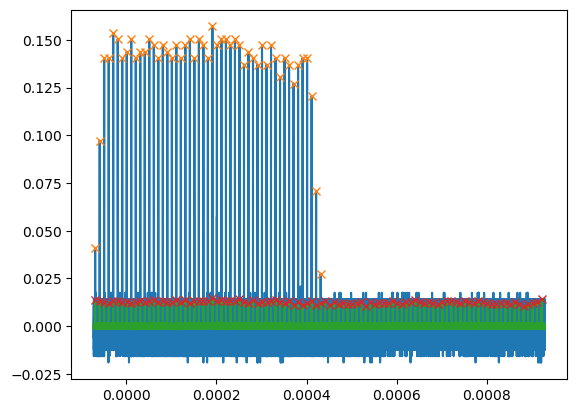

In [4]:
#Next we want to find the signal and control peaks...

#redefine the trimmed arrays as the new arrays to overwrite them

tCH1 = tCH11
yCH1 = yCH11

tCH3 = tCH31
yCH3 = yCH31

tCH4 = tCH41
yCH4 = yCH41

tCHSum1and3 = tCHSum1and31
yCHSum1and3 = yCHSum1and31

#spacing between peaks at 100 kHz should be 10us
#we have a sample rate of 5Gsamples/s
#this should be 50,000 samples between each pulse 

peaksControl, _ = find_peaks(yCH4, prominence=0.04, distance=49980, width = 2) #finding the control peaks in the trace
peaksSumDetector, _ = find_peaks(yCHSum1and3, prominence=0.005, distance=49980,  width = 2) #finding the signal peaks in the trace

plt.plot(tCH4, yCH4)  #plotting the data from the dataframe for the control channel
plt.plot(tCH4[peaksControl], yCH4[peaksControl], "x") #plotting the peaks

plt.plot(tCHSum1and3, yCHSum1and3)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(tCHSum1and3[peaksSumDetector], yCHSum1and3[peaksSumDetector], "x") #plotting the peaks

print(len(peaksControl))
print(len(peaksSumDetector))

#calculating the spacing in time between the peaks

SpacingBetweenPeaksC = (peaksControl[-1]-peaksControl[0])/(len(peaksControl)-1)
print(SpacingBetweenPeaksC,'SpacingBetweenPeaksC')

SpacingBetweenPeaks = (peaksSumDetector[-1]-peaksSumDetector[0])/(len(peaksSumDetector)-1)
print(SpacingBetweenPeaks,'SpacingBetweenPeaks')

(0.00022109257, 0.00022115257)

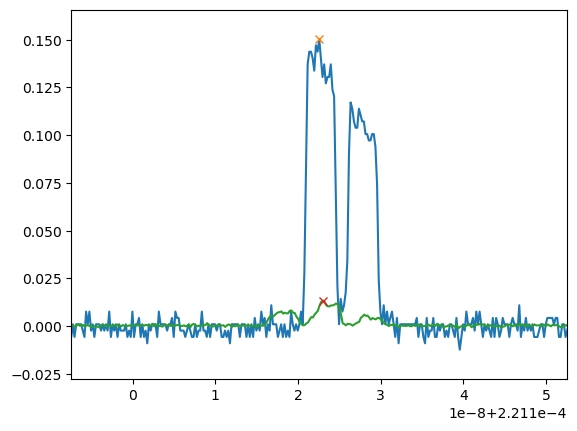

In [5]:
plt.plot(tCH4, yCH4)  #plotting the data from the dataframe for the control channel
plt.plot(tCH4[peaksControl], yCH4[peaksControl], "x") #plotting the peaks

plt.plot(tCHSum1and3, yCHSum1and3)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(tCHSum1and3[peaksSumDetector], yCHSum1and3[peaksSumDetector], "x") #plotting the peaks

plt.xlim((tCH4[(peaksControl[29])])-30*10**-9,(tCH4[(peaksControl[29])])+30*10**-9) #plotting the data around a specific peak given by the index in the square brackets

#it looks like we are consistently finding the first control pulse peak and the middle signal detetector peak 
#which are the ones of interest
#what we should do is take our data with respect to the control pulse data...
#we now want to find the centre of the control pulse peak and signal pulse peak
#then we can find the shift between the centre of the two peaks
#and then we can work out what limits we want for the pulse integration with respect to the position of the centre
#of the control pulse peak
#we can then extrapolate from the times when the control pulse is on, to the times when the control pulse
#is off, but the signal should still be on!

In [6]:
#finding the width of the control and signal peaks

results_halfControl = peak_widths(yCH4, peaksControl, rel_height=0.7)

results_halfControl[0]  # widths
print(yCH4[peaksControl])
#print(results_halfControl[0], 'width of control peak in samples')
#print(results_halfControl[1], 'Amplitude of evaluation for control peak width in samples')
#print(results_halfControl[2], 'Index of left side of peak at amplitude of evaluation  control in samples')
#print(results_halfControl[3], 'Index of right side of peak at amplitude of evaluation control in samples')

results_halfSignal = peak_widths(yCHSum1and3, peaksSumDetector, rel_height=0.7)

results_halfSignal[0]  # widths
print(yCH4[peaksSumDetector])
#print(results_halfSignal[0], 'width of Signal peak in samples')
#print(results_halfSignal[1], 'Amplitude of evaluation for Signal peak width in samples')
#print(results_halfSignal[2], 'Index of left side of peak at amplitude of evaluation Signal in samples')
#print(results_halfSignal[3], 'Index of right side of peak at amplitude of evaluation Signal in samples')

#finding the centre of the control and signal peaks

#minus 4 from the centre of the signal peak as the signal peak centre at 4ns is slightly shifted to the right compared
#to the shorter pulse durations! 

IndexCentreControlPeak = (((results_halfControl[3]-results_halfControl[2])/2)+results_halfControl[2]).astype(int)
IndexCentreSignalPeak = (((results_halfSignal[3]-results_halfSignal[2])/2)+results_halfSignal[2]).astype(int) 

print(IndexCentreControlPeak)
print(IndexCentreSignalPeak)

#finding the spacing between a signal and control peak of the same index 

print(IndexCentreControlPeak[11]-IndexCentreSignalPeak[11])

IndexCentreSignalPeakRelControl = IndexCentreControlPeak + 2 

TimeBetweenIndices = 1/SampleRate

print(TimeBetweenIndices,'TimeBetweenIndices')

#the delay between the signal and control channels is roughly 2 or 3 samples at 5GSamples/s
#the control is 2 or 3 samples before the signal 
#so if we take the centre of the control and add 2 samples onto it, then this should roughly be the centre of the signal

[0.0407577 0.0972136 0.140386  0.140386  0.15367   0.150349  0.140386
 0.143707  0.150349  0.140386  0.143707  0.143707  0.150349  0.147028
 0.140386  0.147028  0.143707  0.140386  0.147028  0.140386  0.147028
 0.150349  0.140386  0.150349  0.147028  0.140386  0.15699   0.147028
 0.150349  0.150349  0.147028  0.150349  0.147028  0.137065  0.143707
 0.140386  0.137065  0.147028  0.137065  0.147028  0.140386  0.130423
 0.140386  0.137065  0.127102  0.137065  0.140386  0.140386  0.12046
 0.0706461 0.027474 ]
[ 0.0341158   0.0905717   0.127102    0.130423    0.140386    0.130423
  0.133744    0.0374368   0.130423    0.12046     0.133744    0.127102
  0.123781    0.137065    0.12046     0.133744    0.130423    0.130423
  0.133744    0.130423    0.140386    0.137065    0.130423    0.137065
  0.137065    0.123781    0.140386    0.133744    0.130423    0.130423
  0.133744    0.133744    0.133744    0.127102    0.127102    0.127102
  0.12046     0.130423    0.130423    0.133744    0.133744    0

(0.000231091606, 0.00023115160600000001)

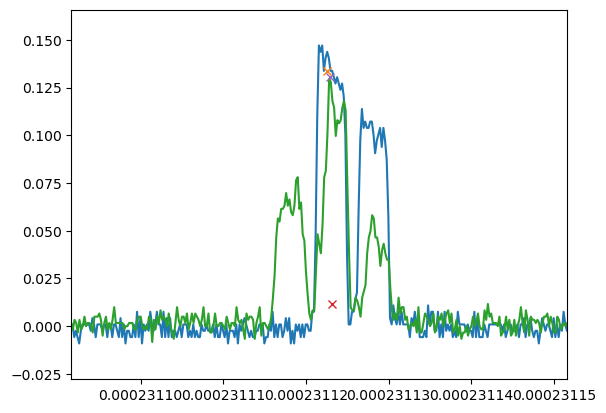

In [7]:
plt.plot(tCH4+2*TimeBetweenIndices, yCH4)  #plotting the data from the dataframe for the control channel
plt.plot(tCH4[IndexCentreControlPeak], yCH4[IndexCentreControlPeak], "x") #plotting the peaks

plt.plot(tCHSum1and3, yCHSum1and3*10)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(tCHSum1and3[IndexCentreSignalPeak], yCHSum1and3[IndexCentreSignalPeak], "x") #plotting the peaks

plt.plot(tCH4[IndexCentreSignalPeakRelControl], yCH4[IndexCentreSignalPeakRelControl], "x") #plotting the shifted control peaks

plt.xlim((tCHSum1and3[(peaksControl[30])])-30*10**-9,(tCHSum1and3[(peaksControl[30])])+30*10**-9) #plotting the data around a specific peak given by the index in the square brackets

#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns

In [8]:
#We now know the positions of the control pulses and the relative spacings between the signal and control pulses
#we must now construct an array of the positions of the signal pulses relative to the control pulse

#we want to compare control pulse 10 to 40, with signal pulse 60 to 90
#that way we can get some means and standard deviations 

#defining a linspace for the indices that we wish to use in the calculations for the control on and control off
#and then converting these to be integers 

ControlPulseIndex = np.linspace(10,40,31)
ControlPulseIndex = ControlPulseIndex.astype(int)

NoControlPulseIndex = np.linspace(60,90,31)
NoControlPulseIndex = NoControlPulseIndex.astype(int)

NumberOfIndicesControlOnAndOff = NoControlPulseIndex[0] - ControlPulseIndex[0]

StartIndex = 12
EndIndex = 12

#now we relate the control pulse and signal pulse times 

#Constructing arrays with control pulse on 

SignalCentreTimeControlIndex = IndexCentreControlPeak + 3
SignalCentreTimeControlIndex = SignalCentreTimeControlIndex.astype(int)

SignalCentreTimeControl = tCHSum1and3[IndexCentreControlPeak] + 2*TimeBetweenIndices #This gets us the time for the centre of pulses with the control on

SignalCentreTimeControlStartLim = SignalCentreTimeControl -StartIndex*TimeBetweenIndices
SignalCentreTimeControlEndLim = SignalCentreTimeControl + EndIndex*TimeBetweenIndices

SignalCentreTimeControlIndexStartLim = SignalCentreTimeControlIndex - StartIndex
SignalCentreTimeControlIndexEndLim = SignalCentreTimeControlIndex + EndIndex

print(SignalCentreTimeControl[ControlPulseIndex])

#Constructing arrays for no control pulse

SignalCentreTimeNoControlIndex = IndexCentreSignalPeak 
SignalCentreTimeNoControlIndex = SignalCentreTimeNoControlIndex.astype(int)

print(SignalCentreTimeNoControlIndex)

SignalCentreTimeNoControl = tCHSum1and3[IndexCentreSignalPeak]  #This gives us the time for the centre of the pulses with no control

SignalCentreTimeNoControlStartLim = SignalCentreTimeNoControl -StartIndex*TimeBetweenIndices
SignalCentreTimeNoControlEndLim = SignalCentreTimeNoControl + EndIndex*TimeBetweenIndices

SignalCentreTimeNoControlIndexStartLim = SignalCentreTimeNoControlIndex - StartIndex
SignalCentreTimeNoControlIndexEndLim = SignalCentreTimeNoControlIndex + EndIndex

print(SignalCentreTimeNoControl[ControlPulseIndex])
print(SignalCentreTimeNoControlStartLim)
print(SignalCentreTimeNoControlEndLim)

print(len(IndexCentreSignalPeak),'len(IndexCentreSignalPeak)')
print(len(IndexCentreControlPeak),'len(IndexCentreControlPeak)')

#print(IndexCentreSignalPeak,'IndexCentreSignalPeak')
#print(IndexCentreControlPeak,'IndexCentreControlPeak')

[3.11234060e-05 4.11240060e-05 5.11240060e-05 6.11238060e-05
 7.11238060e-05 8.11236060e-05 9.11232060e-05 1.01123406e-04
 1.11123206e-04 1.21123206e-04 1.31123006e-04 1.41123406e-04
 1.51124006e-04 1.61123806e-04 1.71123606e-04 1.81123606e-04
 1.91123406e-04 2.01123406e-04 2.11123206e-04 2.21123006e-04
 2.31123006e-04 2.41122806e-04 2.51123606e-04 2.61123806e-04
 2.71123806e-04 2.81123606e-04 2.91123406e-04 3.01123206e-04
 3.11123206e-04 3.21123006e-04 3.31123206e-04]
[  15626   65625  115624  165623  215622  265621  315620  365619  415619
  465617  515619  565622  615622  665621  715621  765620  815618  865619
  915618  965617 1015616 1065619 1115622 1165621 1215619 1265620 1315619
 1365618 1415617 1465617 1515617 1565615 1615620 1665621 1715620 1765619
 1815619 1865618 1915618 1965616 2015618 2065616 2115614 2165619 2215620
 2265619 2315619 2365618 2415617 2465616 2515616 2565615 2615614 2665613
 2715618 2765619 2815617 2865617 2915616 2965615 3015615 3065614 3115613
 3165612 321561

(0.0005310936059999999, 0.000531153606)

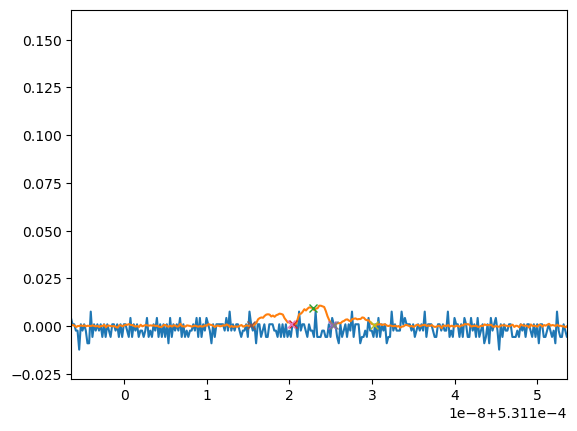

In [9]:
plt.plot(tCH4+2*TimeBetweenIndices, yCH4)  #plotting the data from the dataframe for the control channel
#plt.plot(tCH4[IndexCentreControlPeak], yCH4[IndexCentreControlPeak], "x") #plotting the peaks

plt.plot(tCHSum1and3, yCHSum1and3)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(SignalCentreTimeNoControl, yCHSum1and3[SignalCentreTimeNoControlIndex], "x") #plotting the peaks

plt.plot(SignalCentreTimeNoControlStartLim, yCHSum1and3[SignalCentreTimeNoControlIndexStartLim], "x") #plotting the peaks
plt.plot(SignalCentreTimeNoControlEndLim, yCHSum1and3[SignalCentreTimeNoControlIndexEndLim], "x") #plotting the peaks

#determining the limits for the first peak

plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexStartLim-25], yCHSum1and3[SignalCentreTimeNoControlIndexStartLim-25], "x") #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexEndLim-25], yCHSum1and3[SignalCentreTimeNoControlIndexEndLim-25], "x") #plotting the peaks

#determining the limits for the last peak

plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexStartLim+25], yCHSum1and3[SignalCentreTimeNoControlIndexStartLim+25], "x") #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexEndLim+25], yCHSum1and3[SignalCentreTimeNoControlIndexEndLim+25], "x") #plotting the peaks

#plt.plot(tCH4[IndexCentreSignalPeakRelControl], yCH4[IndexCentreSignalPeakRelControl], "x") #plotting the shifted control peaks

plt.xlim((tCHSum1and3[(peaksSumDetector[60])])-30*10**-9,(tCHSum1and3[(peaksSumDetector[60])])+30*10**-9) #plotting the data around a specific peak given by the index in the square brackets
#plt.ylim(0,0.1)
#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns


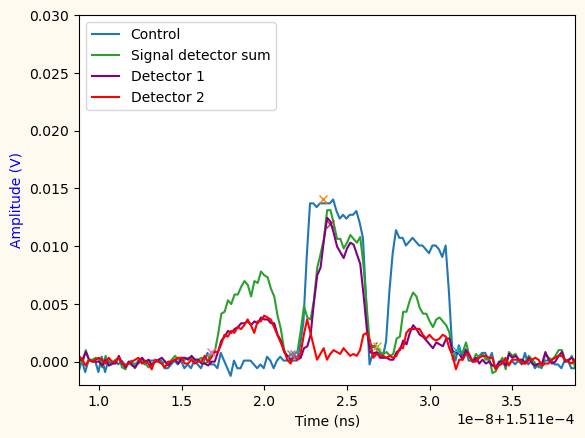

In [10]:
fig, ax = plt.subplots()

a = 0 #off-set to 0 time 

CH4, = plt.plot(tCH4+3*TimeBetweenIndices, yCH4*0.1)  #plotting the data from the dataframe for the control channel
plt.plot(tCH4[IndexCentreControlPeak], yCH4[IndexCentreControlPeak]*0.1, "x") #plotting the peaks

CH13,= plt.plot(tCHSum1and3, yCHSum1and3)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(SignalCentreTimeControl, yCHSum1and3[SignalCentreTimeControlIndex], "x") #plotting the peaks

CH1, = plt.plot(tCH1, yCH1, c = 'purple') 
CH3, = plt.plot(tCH3, yCH3, c = 'red') 

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexStartLim], yCHSum1and3[SignalCentreTimeControlIndexStartLim], "x") #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeControlIndexEndLim], yCHSum1and3[SignalCentreTimeControlIndexEndLim], "x") #plotting the peaks

#determining the limits for the first peak

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexStartLim-25], yCHSum1and3[SignalCentreTimeControlIndexStartLim-25], "x") #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeControlIndexEndLim-25], yCHSum1and3[SignalCentreTimeControlIndexEndLim-25], "x") #plotting the peaks

#determining the limits for the last peak

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexStartLim+25], yCHSum1and3[SignalCentreTimeControlIndexStartLim+25], "x") #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeControlIndexEndLim+25], yCHSum1and3[SignalCentreTimeControlIndexEndLim+25], "x") #plotting the peaks

#plt.plot(tCH4[IndexCentreSignalPeakRelControl], yCH4[IndexCentreSignalPeakRelControl], "x") #plotting the shifted control peaks

plt.xlim((tCHSum1and3[(peaksSumDetector[22])])-15*10**-9,(tCHSum1and3[(peaksSumDetector[22])])+15*10**-9) #plotting the data around a specific peak given by the index in the square brackets
plt.ylim(-0.002,0.030)
#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns

#doesn't seem to work using the control to find the future pulses...
#let's instead use the centre of the signal peaks to find the integration limits for the peak 

ax.legend([CH4, CH13, CH1, CH3], ['Control','Signal detector sum','Detector 1','Detector 2'], loc='upper left')

plt.xlabel("Time (ns)")
plt.ylabel('Amplitude (V)', color='b')

plt.savefig('Pulsed switching 4ns 193.1696 THz control on repeat 5.png', dpi=400)

fig.patch.set_facecolor('floralwhite')
fig.patch.set_alpha(1)

plt.show()

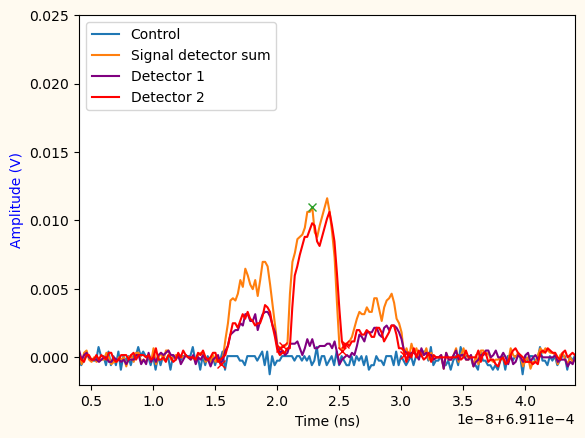

In [11]:
fig, ax = plt.subplots()

a = 0 #off-set to 0 time 

CH4, = plt.plot(tCH4+2*TimeBetweenIndices, yCH4*0.1)  #plotting the data from the dataframe for the control channel
#plt.plot(tCH4[IndexCentreControlPeak], yCH4[IndexCentreControlPeak], "x") #plotting the peaks

CH13, = plt.plot(tCHSum1and3, yCHSum1and3)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(SignalCentreTimeNoControl, yCHSum1and3[SignalCentreTimeNoControlIndex], "x") #plotting the peaks

CH1, = plt.plot(tCH1, yCH1, c = 'purple') 
CH3, = plt.plot(tCH3, yCH3, c = 'red') 

plt.plot(SignalCentreTimeNoControlStartLim, yCHSum1and3[SignalCentreTimeNoControlIndexStartLim], "x",c = 'red') #plotting the peaks
plt.plot(SignalCentreTimeNoControlEndLim, yCHSum1and3[SignalCentreTimeNoControlIndexEndLim], "x",c = 'red') #plotting the peaks

#determining the limits for the first peak

plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexStartLim-25], yCHSum1and3[SignalCentreTimeNoControlIndexStartLim-25], "x",c = 'red') #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexEndLim-25], yCHSum1and3[SignalCentreTimeNoControlIndexEndLim-25], "x",c = 'red') #plotting the peaks

#determining the limits for the last peak

plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexStartLim+25], yCHSum1and3[SignalCentreTimeNoControlIndexStartLim+25], "x",c = 'red') #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeNoControlIndexEndLim+25], yCHSum1and3[SignalCentreTimeNoControlIndexEndLim+25], "x",c = 'red') #plotting the peaks

plt.xlim((tCHSum1and3[(peaksSumDetector[76])])-20*10**-9,(tCHSum1and3[(peaksSumDetector[76])])+20*10**-9) #plotting the data around a specific peak given by the index in the square brackets
plt.ylim(-0.002,0.025)
#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns


plt.xlabel("Time (ns)")
plt.ylabel('Amplitude (V)', color='b')

plt.savefig('Pulsed switching 4ns 193.1696 THz control off repeat 5.png', dpi=400)

ax.legend([CH4, CH13, CH1, CH3], ['Control','Signal detector sum','Detector 1','Detector 2'], loc='upper left')

fig.patch.set_facecolor('floralwhite')
fig.patch.set_alpha(1)

plt.show()

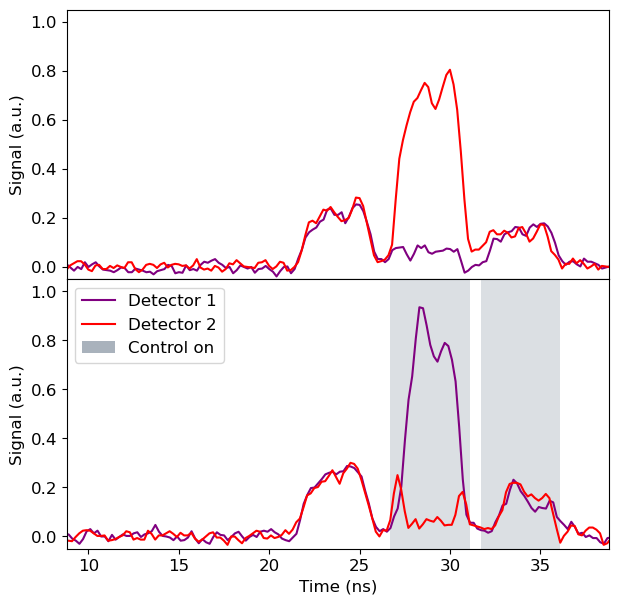

In [12]:
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle

#Plotting a comparison of a set of peaks with the control on vs the control off and two different subplots,
#one on top of the other

plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(2)

a = 6.911*10**5 #off-set to 0 time 

yCH1filt = gaussian_filter(yCH1, sigma=0.6)
yCH3filt = gaussian_filter(yCH3, sigma=0.6)

MaxForNormalising = np.amax(yCH1filt)

CH1, = axs[0].plot(tCH1*10**9-a+6, yCH1filt/MaxForNormalising, c = 'purple') 
CH3, = axs[0].plot(tCH3*10**9-a+6, yCH3filt/MaxForNormalising, c = 'red') 

axs[0].set_xlim((tCHSum1and3[(peaksSumDetector[76])])*10**9-15-a,(tCHSum1and3[(peaksSumDetector[76])])*10**9+15-a) #plotting the data around a specific peak given by the index in the square brackets
axs[0].set_ylim(-0.05,1.05)
#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns
    
rect = Rectangle((0, 0), 1, 1, fc="slategrey", alpha=0.6)

plt.xlabel("Time (ns)")
axs[0].set_ylabel('Signal (a.u.)')

axs[1].legend([CH1, CH3, rect], ['Detector 1','Detector 2', 'Control on'], loc='upper left')

a = 1.511*10**5 #off-set to 0 time 

CH1, = axs[1].plot(tCH1*10**9-a+4.5, yCH1filt/MaxForNormalising, c = 'purple') 
CH3, = axs[1].plot(tCH3*10**9-a+4.5, yCH3filt/MaxForNormalising, c = 'red') 

axs[1].set_xlim((tCHSum1and3[(peaksSumDetector[22])])*10**9-15-a,(tCHSum1and3[(peaksSumDetector[22])])*10**9+15-a) #plotting the data around a specific peak given by the index in the square brackets
axs[1].set_ylim(-0.05,1.05)
#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns

axs[1].set_ylabel('Signal (a.u.)')

#limits for shaded regions

a = 22.2+4.5
b = 26.6+4.5

a2 = 27.2+4.5
b2 = 31.6+4.5

plt.axvspan(a, b, color='slategrey', alpha=0.25, lw=0)

plt.axvspan(a2, b2, color='slategrey', alpha=0.25, lw=0)

fig.set_figheight(7) #sets the size of the subplot figure
fig.set_figwidth(7)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.subplots_adjust(hspace=0)

plt.savefig('Pulsed switching 4ns 193.1696 THz control on and off repeat 5 subplots new.png', dpi=400, bbox_inches='tight', pad_inches = 0)
plt.savefig('Pulsed switching 4ns 193.1696 THz control on and off repeat 5 subplots new.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)

plt.show()

1115620 (peaksSumDetector[22])
151123.806 tCHSum1and3[peaksSumDetector[22]]*10**9
540024.0059 tCHSum1and3[(peaksSumDetector[76])]*10**9-a
388900.1999 DifferenceBetweenTraces
[-7.20000050e-05 -7.19998050e-05 -7.19996050e-05 ...  9.27999595e-04
  9.27999795e-04  9.27999995e-04]


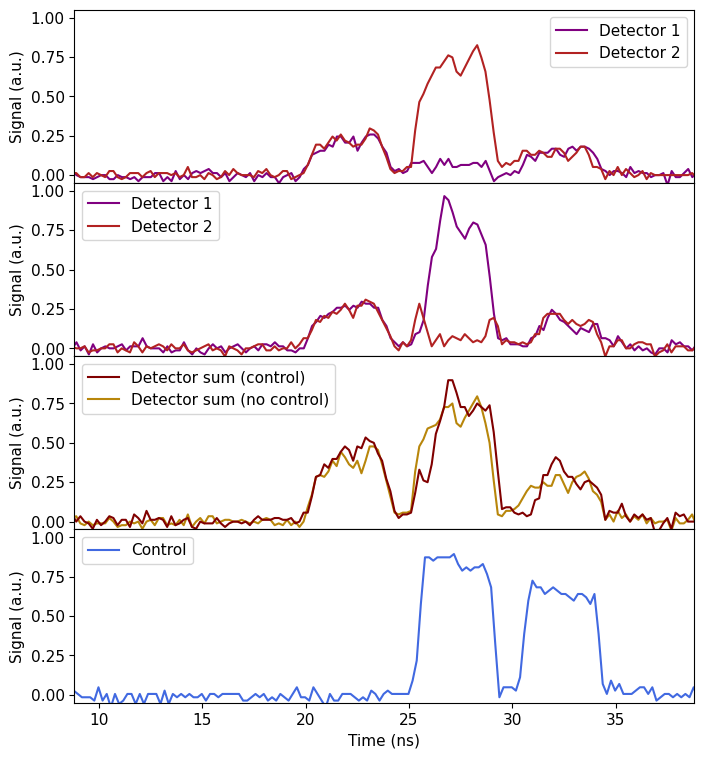

In [13]:
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle

#Plotting a signal pulse with the control on, control off, and the sum of the detector channels, and the control channel

plt.rcParams.update({'font.size': 11})

CHSum = yCH1+yCH3
CHSum1 = CHSum
CHSum2 = CHSum
CHSum3 = CHSum

MaxForNormalisingCHSum = np.amax(CHSum)

fig, axs = plt.subplots(4)

MaxForNormalisingControl = np.amax(yCH41)

a = 6.911*10**5#705300*10**-9#399810*10**-9 #off-set to 0 time 

a1 = 6.911*10**5

CH1, = axs[0].plot(tCH1*10**9-a+4.3, yCH1/MaxForNormalising, c = 'purple') 
CH3, = axs[0].plot(tCH3*10**9-a+4.3, yCH3/MaxForNormalising, c = 'firebrick') 

axs[0].set_xlim((tCHSum1and3[(peaksSumDetector[76])])*10**9-15-a,(tCHSum1and3[(peaksSumDetector[76])])*10**9+15-a) #plotting the data around a specific peak given by the index in the square brackets
axs[0].set_ylim(-0.05,1.05)

rect = Rectangle((0, 0), 1, 1, fc="slategrey", alpha=0.6)

plt.xlabel("Time (ns)")
axs[0].set_ylabel('Signal (a.u.)')

axs[0].legend([CH1, CH3], ['Detector 1','Detector 2'], loc='upper right')
axs[1].legend([CH1, CH3], ['Detector 1','Detector 2'], loc='upper left')

a = 1.511*10**5#705300*10**-9#399810*10**-9 #off-set to 0 time 

CH1, = axs[1].plot(tCH1*10**9-a+2.9, yCH1/MaxForNormalising, c = 'purple') 
CH3, = axs[1].plot(tCH3*10**9-a+2.9, yCH3/MaxForNormalising, c = 'firebrick') 

print((peaksSumDetector[22]), '(peaksSumDetector[22])')

tCHSum1and32ndpeaks = np.linspace((peaksSumDetector[22]-20*5),(peaksSumDetector[22]+20*5),41*5)
tCHSum1and32ndpeaks = tCHSum1and32ndpeaks.astype(int)

print(tCHSum1and3[peaksSumDetector[22]]*10**9,'tCHSum1and3[peaksSumDetector[22]]*10**9')
print(tCHSum1and3[(peaksSumDetector[76])]*10**9-a,'tCHSum1and3[(peaksSumDetector[76])]*10**9-a')

DifferenceBetweenTraces = tCHSum1and3[(peaksSumDetector[76])]*10**9-a-tCHSum1and3[peaksSumDetector[22]]*10**9
print(DifferenceBetweenTraces,'DifferenceBetweenTraces')

print(tCH3)

#CHSum, = axs[2].plot(tCH3*10**9-a1+a-((+tCHSum1and3[(peaksSumDetector[76])])-tCHSum1and3[(peaksSumDetector[22])])*10**9, CHSum/MaxForNormalisingCHSum, c = 'red') 
CHSum1, = axs[2].plot(tCH3*10**9-a+4.3, CHSum1/MaxForNormalisingCHSum, c = 'darkgoldenrod') 

CHSumderp, = axs[2].plot((tCH3[tCHSum1and32ndpeaks])*10**9+DifferenceBetweenTraces+2.9, (CHSum3[tCHSum1and32ndpeaks])/MaxForNormalisingCHSum, c = 'maroon')

CH4, = axs[3].plot(tCH4*10**9-a+3.6, yCH4/MaxForNormalisingControl, c = 'royalblue') 

axs[3].set_ylim(-0.05,1.05)
axs[2].set_ylim(-0.05,1.05)

axs[2].set_xlim((tCHSum1and3[(peaksSumDetector[76])])*10**9-15-a,(tCHSum1and3[(peaksSumDetector[76])])*10**9+15-a) #plotting the data around a specific peak given by the index in the square brackets
axs[3].set_xlim((tCHSum1and3[(peaksSumDetector[22])])*10**9-15-a,(tCHSum1and3[(peaksSumDetector[22])])*10**9+15-a) #plotting the data around a specific peak given by the index in the square brackets

axs[1].set_xlim((tCHSum1and3[(peaksSumDetector[22])])*10**9-15-a,(tCHSum1and3[(peaksSumDetector[22])])*10**9+15-a) #plotting the data around a specific peak given by the index in the square brackets
axs[1].set_ylim(-0.05,1.05)
#so the position of our middle signal peak, is the position of the centre of the first control peak plus 2 indices or 0.4ns

axs[1].set_ylabel('Signal (a.u.)')
axs[2].set_ylabel('Signal (a.u.)')
axs[3].set_ylabel('Signal (a.u.)')

axs[2].legend([CHSumderp, CHSum1], ['Detector sum (control)','Detector sum (no control)'], loc='upper left')
axs[3].legend([CH4], ['Control'], loc='upper left')

a = 22.2+2
b = 26.6+2

a2 = 27.2+2
b2 = 31.6+2

fig.set_figheight(9) #sets the size of the subplot figure
fig.set_figwidth(8)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.subplots_adjust(hspace=0)

plt.savefig('Pulsed switching 4ns 193.1696 THz control on and off repeat 5 subplots new.png', dpi=400, bbox_inches='tight', pad_inches = 0)
plt.savefig('Pulsed switching 4ns 193.1696 THz control on and off repeat 5 subplots new.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)

plt.show()

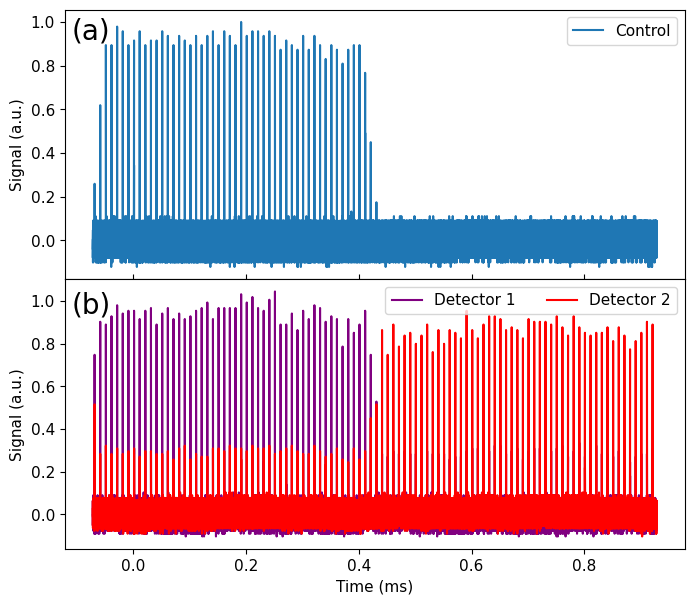

In [14]:
#Plotting all 100 signal pulses being analysed + the control pulses

fig, axs = plt.subplots(2,sharex='all')

MaxForNormalisingControl = np.amax(yCH41)

CH1, = axs[1].plot(tCH11*10**3, yCH11/MaxForNormalising, c = 'purple')
CH3, = axs[1].plot(tCH31*10**3, yCH31/MaxForNormalising,  c = 'red')
CH4, = axs[0].plot(tCH41*10**3, yCH41/MaxForNormalisingControl)

axs[0].legend([CH4], ['Control'], loc='upper right')
axs[1].legend([CH1, CH3], ['Detector 1','Detector 2'], loc='upper right', ncol=2)

axs[1].set_ylabel('Signal (a.u.)')
axs[0].set_ylabel('Signal (a.u.)')
plt.xlabel("Time (ms)")

#plt.plot(tCHSum1and31*10**9, yCHSum1and31)

fig.subplots_adjust(hspace=0)

axs[0].tick_params(axis="x",direction="in", pad=-15)

axs[0].text(-0.11,0.92,'(a)',rotation=0, fontsize="20")
axs[1].text(-0.11,0.94,'(b)',rotation=0, fontsize="20")

#axs[1].set_ylim(-2,14.5)

fig.set_figheight(7) #sets the size of the subplot figure
fig.set_figwidth(8)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

plt.savefig('Pulsed switching 4ns 193.1696 THz control off repeat 5 subplots control on and off zoomed out thesis.png', dpi=400, bbox_inches='tight', pad_inches = 0)
plt.savefig('Pulsed switching 4ns 193.1696 THz control off repeat 5 subplots control on and off zoomed out thesis.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)


plt.show()

In [15]:
#We now have an array of start and end times for all the peaks with the control on and the control off
#we now want to work out the areas of these signal peaks and make a comparison of the peaks with the control on vs off
#but we only want to use a range of peaks in the middle as the peaks out to the sides will be partially chopped 

#we want to use scipy's trapezoid function to integrate and find the area under the curve 

SignalCentreTimeNoControlIndexStartLimPeak1 = SignalCentreTimeNoControlIndex - StartIndex -25
SignalCentreTimeNoControlIndexEndLimPeak1 = SignalCentreTimeNoControlIndex + EndIndex -25

SignalCentreTimeNoControlIndexStartLimPeak3 = SignalCentreTimeNoControlIndex - StartIndex +25
SignalCentreTimeNoControlIndexEndLimPeak3 = SignalCentreTimeNoControlIndex + EndIndex +25

SignalCentreTimeControlIndexStartLimPeak1 = SignalCentreTimeControlIndex - StartIndex -25
SignalCentreTimeControlIndexEndLimPeak1 = SignalCentreTimeControlIndex + EndIndex -25

SignalCentreTimeControlIndexStartLimPeak3 = SignalCentreTimeControlIndex - StartIndex +25
SignalCentreTimeControlIndexEndLimPeak3 = SignalCentreTimeControlIndex + EndIndex +25


#With no control pulse:

dx = TimeBetweenIndices

#define our empty arrays for the areas with no control field

PulseAreasCHSum1and3NC = []
PulseAreasCHSum1and3NCPeak1 = []
PulseAreasCHSum1and3NCPeak3 = []
PulseAreasCH1NC = []
PulseAreasCH3NC = []
PulseAreasCH1NCPeak1 = []
PulseAreasCH3NCPeak1 = []
PulseAreasCH1NCPeak3 = []
PulseAreasCH3NCPeak3 = []

#we loop over the index for no control pulse

for i in NoControlPulseIndex:
    areaCH1 = np.trapz(yCH1[SignalCentreTimeNoControlIndexStartLim[i]:SignalCentreTimeNoControlIndexEndLim[i]], dx = dx)
    areaCH3 = np.trapz(yCH3[SignalCentreTimeNoControlIndexStartLim[i]:SignalCentreTimeNoControlIndexEndLim[i]], dx = dx)
    areaCH1Peak1 = np.trapz(yCH1[SignalCentreTimeNoControlIndexStartLimPeak1[i]:SignalCentreTimeNoControlIndexEndLimPeak1[i]], dx = dx)
    areaCH3Peak1 = np.trapz(yCH3[SignalCentreTimeNoControlIndexStartLimPeak1[i]:SignalCentreTimeNoControlIndexEndLimPeak1[i]], dx = dx)
    areaCH1Peak3 = np.trapz(yCH1[SignalCentreTimeNoControlIndexStartLimPeak3[i]:SignalCentreTimeNoControlIndexEndLimPeak3[i]], dx = dx)
    areaCH3Peak3 = np.trapz(yCH3[SignalCentreTimeNoControlIndexStartLimPeak3[i]:SignalCentreTimeNoControlIndexEndLimPeak3[i]], dx = dx)
    areaCHSum1and3 = np.trapz(yCHSum1and3[SignalCentreTimeNoControlIndexStartLim[i]:SignalCentreTimeNoControlIndexEndLim[i]], dx = dx)
    areaCHSum1and3Peak1 = np.trapz(yCHSum1and3[SignalCentreTimeNoControlIndexStartLimPeak1[i]:SignalCentreTimeNoControlIndexEndLimPeak1[i]], dx = dx)
    areaCHSum1and3Peak3 = np.trapz(yCHSum1and3[SignalCentreTimeNoControlIndexStartLimPeak3[i]:SignalCentreTimeNoControlIndexEndLimPeak3[i]], dx = dx)
    PulseAreasCHSum1and3NC.append(areaCHSum1and3)
    PulseAreasCHSum1and3NCPeak1.append(areaCHSum1and3Peak1)
    PulseAreasCHSum1and3NCPeak3.append(areaCHSum1and3Peak3)
    PulseAreasCH1NC.append(areaCH1)
    PulseAreasCH3NC.append(areaCH3)
    PulseAreasCH1NCPeak1.append(areaCH1Peak1)
    PulseAreasCH3NCPeak1.append(areaCH3Peak1)
    PulseAreasCH1NCPeak3.append(areaCH1Peak3)
    PulseAreasCH3NCPeak3.append(areaCH3Peak3)

#we calculate the areas using trapz for each of the channels and the sum of the channels with the limits defined by the indices
#which are given by the index of the start for each of the peaks given by i 
#so i is the peak that we want to use in the analysis and SignalCentreTimeNoControlIndexStartLim[i] is the index
#for the y value that corresponds to the start of that peak, and vice versa for the end of the peak
    
#With control pulse 

#define our empty arrays for the areas with control field on

PulseAreasCHSum1and3C = []
PulseAreasCHSum1and3CPeak1 = []
PulseAreasCHSum1and3CPeak3 = []
PulseAreasCH1C = []
PulseAreasCH3C = []

#we loop over the index for with control pulse on

for i in ControlPulseIndex:
    areaCH1 = np.trapz(yCH1[SignalCentreTimeControlIndexStartLim[i]:SignalCentreTimeControlIndexEndLim[i]], dx = dx)
    areaCH3 = np.trapz(yCH3[SignalCentreTimeControlIndexStartLim[i]:SignalCentreTimeControlIndexEndLim[i]], dx = dx)
    areaCHSum1and3 = np.trapz(yCHSum1and3[SignalCentreTimeControlIndexStartLim[i]:SignalCentreTimeControlIndexEndLim[i]], dx = dx)
    areaCHSum1and3Peak1 = np.trapz(yCHSum1and3[SignalCentreTimeControlIndexStartLimPeak1[i]:SignalCentreTimeControlIndexEndLimPeak1[i]], dx = dx)
    areaCHSum1and3Peak3 = np.trapz(yCHSum1and3[SignalCentreTimeControlIndexStartLimPeak3[i]:SignalCentreTimeControlIndexEndLimPeak3[i]], dx = dx)
    PulseAreasCHSum1and3C.append(areaCHSum1and3)
    PulseAreasCHSum1and3CPeak1.append(areaCHSum1and3Peak1)
    PulseAreasCHSum1and3CPeak3.append(areaCHSum1and3Peak3)
    PulseAreasCH1C.append(areaCH1)
    PulseAreasCH3C.append(areaCH3)

#description as above but repeated for integrating when the control pulse is on

print(PulseAreasCHSum1and3C)


[3.672957860000001e-11, 3.5384575399999996e-11, 3.6928821700000004e-11, 3.58328988e-11, 3.4288638300000004e-11, 3.68126034e-11, 3.55007998e-11, 3.48698401e-11, 3.63808688e-11, 3.58162861e-11, 3.70450126e-11, 3.5799663700000005e-11, 3.7045017499999994e-11, 3.84398129e-11, 3.8356790499999996e-11, 3.697863159999999e-11, 3.8522852000000005e-11, 3.77092459e-11, 3.86889184e-11, 3.805790059999999e-11, 3.72110856e-11, 3.83070081e-11, 3.83401971e-11, 3.6048757100000004e-11, 3.676274e-11, 3.66797061e-11, 3.43550704e-11, 3.59159247e-11, 3.61483796e-11, 3.6895605200000006e-11, 3.68624112e-11]


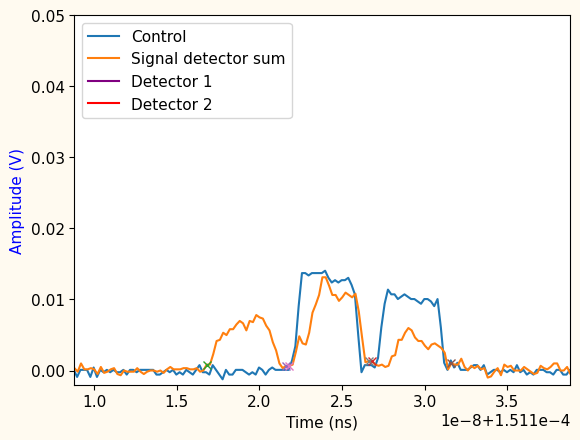

In [16]:
fig, ax = plt.subplots()

a = 0#705300*10**-9 #off-set to 0 time 

CH4, = plt.plot(tCH4+2*TimeBetweenIndices, yCH4*0.1)  #plotting the data from the dataframe for the control channel
#plt.plot(tCH4[IndexCentreControlPeak], yCH4[IndexCentreControlPeak]*0.1, "x") #plotting the peaks

CH13,= plt.plot(tCHSum1and3, yCHSum1and3)  #plotting the data from the dataframe for the sum of both channels 

#determining the limits for the first peak

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexStartLimPeak1], yCHSum1and3[SignalCentreTimeControlIndexStartLimPeak1], "x") #plotting the peaks

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexStartLimPeak3], yCHSum1and3[SignalCentreTimeControlIndexStartLimPeak3], "x") #plotting the peaks

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexEndLimPeak1], yCHSum1and3[SignalCentreTimeControlIndexEndLimPeak1], "x") #plotting the peaks

plt.plot(tCHSum1and3[SignalCentreTimeControlIndexEndLimPeak3], yCHSum1and3[SignalCentreTimeControlIndexEndLimPeak3], "x") #plotting the peaks


plt.plot(tCHSum1and3[SignalCentreTimeControlIndexStartLim], yCHSum1and3[SignalCentreTimeControlIndexStartLim], "x") #plotting the peaks
plt.plot(tCHSum1and3[SignalCentreTimeControlIndexEndLim], yCHSum1and3[SignalCentreTimeControlIndexEndLim], "x") #plotting the peaks

#determining the limits for the last peak

plt.xlim((tCHSum1and3[(peaksSumDetector[22])])-15*10**-9,(tCHSum1and3[(peaksSumDetector[22])])+15*10**-9) #plotting the data around a specific peak given by the index in the square brackets
plt.ylim(-0.002,0.05)

ax.legend([CH4, CH13, CH1, CH3], ['Control','Signal detector sum','Detector 1','Detector 2'], loc='upper left')

plt.xlabel("Time (ns)")
plt.ylabel('Amplitude (V)', color='b')

#plt.savefig('Pulsed switching 4ns 193.1702 THz control on repeat 1.png', dpi=400)

fig.patch.set_facecolor('floralwhite')
fig.patch.set_alpha(1)

plt.show()

In [17]:
import statsmodels.api as sm

#We now have the areas of each of the peaks in each of the channels with the control on and the control off
#therefore we can now begin the analysis
#we must first calculate the phase and two photon absorption 

#Let's assume the interferometer visibility is maximum and so the channels go between 0 and a maximum value
#this is a good assumption from the CW experiment with the polarisation in the interferometer set for maximum interference 
#(i.e. the same polarisation out from both interferometer arms)

#convert lists to numpy arrays

PulseAreasCHSum1and3NC1 = np.asarray(PulseAreasCHSum1and3NC)
PulseAreasCHSum1and3NC = PulseAreasCHSum1and3NC1 

PulseAreasCHSum1and3C1 = np.asarray(PulseAreasCHSum1and3C)
PulseAreasCHSum1and3C = PulseAreasCHSum1and3C1 

PulseAreasCHSum1and3NC1Peak1 = np.asarray(PulseAreasCHSum1and3NCPeak1)
PulseAreasCHSum1and3NCPeak1 = PulseAreasCHSum1and3NC1Peak1

PulseAreasCHSum1and3C1Peak1 = np.asarray(PulseAreasCHSum1and3CPeak1)
PulseAreasCHSum1and3CPeak1 = PulseAreasCHSum1and3C1Peak1 

PulseAreasCHSum1and3NC1Peak3 = np.asarray(PulseAreasCHSum1and3NCPeak3)
PulseAreasCHSum1and3NCPeak3 = PulseAreasCHSum1and3NC1Peak3 

PulseAreasCHSum1and3C1Peak3 = np.asarray(PulseAreasCHSum1and3CPeak3)
PulseAreasCHSum1and3CPeak3 = PulseAreasCHSum1and3C1Peak3 

PulseAreasCH1NC1 = np.asarray(PulseAreasCH1NC)
PulseAreasCH1NC = PulseAreasCH1NC1 

PulseAreasCH3NC1 = np.asarray(PulseAreasCH3NC)
PulseAreasCH3NC = PulseAreasCH3NC1 

PulseAreasCH1C1 = np.asarray(PulseAreasCH1C)
PulseAreasCH1C = PulseAreasCH1C1 

PulseAreasCH3C1 = np.asarray(PulseAreasCH3C)
PulseAreasCH3C = PulseAreasCH3C1 

PulseAreasCH1NCPeak11 = np.asarray(PulseAreasCH1NCPeak1)
PulseAreasCH1NCPeak1 = PulseAreasCH1NCPeak11 

PulseAreasCH3NCPeak11 = np.asarray(PulseAreasCH3NCPeak1)
PulseAreasCH3NCPeak1 = PulseAreasCH3NCPeak11 

PulseAreasCH1NCPeak31 = np.asarray(PulseAreasCH1NCPeak3)
PulseAreasCH1NCPeak3 = PulseAreasCH1NCPeak31 

PulseAreasCH3NCPeak31 = np.asarray(PulseAreasCH3NCPeak3)
PulseAreasCH3NCPeak3 = PulseAreasCH3NCPeak31 

#PulseAreasCH1NCPeak1.append(areaCH1Peak1)
#PulseAreasCH3NCPeak1.append(areaCH3Peak1)
#PulseAreasCH1NCPeak3.append(areaCH1Peak3)
#PulseAreasCH3NCPeak3.append(areaCH3Peak3)

#define P1 and P2 as being equal and being half of total power with no control on 

#P1 = P2 = 0.5*PulseAreasCHSum1and3NC

#from our work with the CW laser it looked like the powers in the two arms of the interferometer were actually similar
#it could be the case that the first splitting out of the signal pulse is much lossier than the second
#and we don't use the first interferometer for the CW experiment

#assume that the polarisation is perfectly overlapping between the two interferometer arms so that gamma = 1

#TransmissionConstant = (PulseAreasCHSum1and3C-P1)/P2 #This is the e^(-2*alpha) term

#TransmissionConstantMean = TransmissionConstant.mean()


T = 1

PulseAreasCHSum1and3NCMean = PulseAreasCHSum1and3NC.mean()
PulseAreasCHSum1and3NCstd = PulseAreasCHSum1and3NC.std()

MiddlePeak = PulseAreasCHSum1and3NCPeak1*T+PulseAreasCHSum1and3NCPeak3/T

MiddlePeakMean = MiddlePeak.mean()
MiddlePeakstd = MiddlePeak.std()

print(PulseAreasCHSum1and3NCMean,'PulseAreasCHSum1and3NCMean')
print(PulseAreasCHSum1and3NCstd,'PulseAreasCHSum1and3NCstd')
print(MiddlePeakMean,'MiddlePeakMean')
print(MiddlePeakstd,'MiddlePeakstd')

#plt.scatter(MiddlePeak,PulseAreasCHSum1and3NC)

#results = sm.OLS(MiddlePeak,sm.add_constant(PulseAreasCHSum1and3NC)).fit()

#print(results.summary())

#X_plot = np.linspace(0,1,100)
#plt.plot(MiddlePeak, MiddlePeak * results.params[1] + results.params[0])

#It looks like the difference in transmission between the two interferometer arms is roughly T = 1 well within 
#the error of the calculations/measurement? 

P1 = PulseAreasCHSum1and3NCPeak1 #P1 defined as the power of the first peak
P2 = PulseAreasCHSum1and3NCPeak3/T  #P2 defined as the power of the last peak divided by the difference in transmission
#between the two arms of the second interferometer
# P1*T + P2 gives the total power in the middle peak 

P1mean = P1.mean()
P2mean = P2.mean()

print(P1.mean(),'P1 mean')
print(P2.mean(),'P2 mean')
print(P2.mean()*T,'P2 mean*T')

print(P2.mean()*T/P1.mean(), 'Ratio of P2*T over P1')

RatioOfPeak3ToPeak1Mean = (PulseAreasCHSum1and3NC1Peak3/PulseAreasCHSum1and3NC1Peak1).mean()
RatioOfPeak3ToPeak1std = (PulseAreasCHSum1and3NC1Peak3/PulseAreasCHSum1and3NC1Peak1).std()
print(RatioOfPeak3ToPeak1Mean,'RatioOfPeak3ToPeak1Mean')
print(RatioOfPeak3ToPeak1std,'RatioOfPeak3ToPeak1std')

#P1 and P2 here are the relative powers out of the first interferometer 
#P1 then experiences any extra relative loss from the second interferometer

#hard to determine exactly what T is! and what P1 and P2 are...
#in the previous CW experiment P1 and P2 were close to having the same value

#we guess the value for T, such that the transmission measured from the ratios of peak 3 area with control vs peak 3 area with no control
#is matching the transmission calculated using P1 and P2 using the middle peak
#This T value is the relative transmission between the two arms in the interferometer 

#PulseAreasCH1NCPeak1.append(areaCH1Peak1)
#PulseAreasCH3NCPeak1.append(areaCH3Peak1)
#PulseAreasCH1NCPeak3.append(areaCH1Peak3)
#PulseAreasCH3NCPeak3.append(areaCH3Peak3)

print(PulseAreasCH1NCPeak1)
print(PulseAreasCH3NCPeak1)

CH1Peak1Mean = PulseAreasCH1NCPeak1.mean()
CH3Peak1Mean = PulseAreasCH3NCPeak1.mean()
CH1Peak1std = PulseAreasCH1NCPeak1.std()
CH3Peak1std = PulseAreasCH3NCPeak1.std()

print(CH1Peak1Mean,'CH1Peak1Mean')
print(CH3Peak1Mean,'CH3Peak1Mean')
print(CH1Peak1std,'CH1Peak1std')
print(CH3Peak1std,'CH3Peak1std')

CH1Peak3Mean = PulseAreasCH1NCPeak3.mean()
CH3Peak3Mean = PulseAreasCH3NCPeak3.mean()
CH1Peak3std = PulseAreasCH1NCPeak3.std()
CH3Peak3std = PulseAreasCH3NCPeak3.std()

print(CH1Peak3Mean,'CH1Peak3Mean')
print(CH3Peak3Mean,'CH3Peak3Mean')
print(CH1Peak3std,'CH1Peak3std')
print(CH3Peak3std,'CH3Peak3std')

print(CH3Peak1Mean/CH1Peak1Mean)
print(CH3Peak3Mean/CH1Peak3Mean)
print((CH3Peak1Mean/CH1Peak1Mean+CH3Peak3Mean/CH1Peak3Mean)/2)

print(P1, 'P1')

3.828823963870967e-11 PulseAreasCHSum1and3NCMean
1.761127058588594e-12 PulseAreasCHSum1and3NCstd
3.748424160645161e-11 MiddlePeakMean
1.8774591675089755e-12 MiddlePeakstd
2.2120639487096772e-11 P1 mean
1.5363602119354838e-11 P2 mean
1.5363602119354838e-11 P2 mean*T
0.6945369788389982 Ratio of P2*T over P1
0.69462468865822 RatioOfPeak3ToPeak1Mean
0.02239643630704731 RatioOfPeak3ToPeak1std
[9.74694240e-12 1.06435960e-11 1.04941548e-11 1.04277355e-11
 1.09424774e-11 1.07930415e-11 1.10753190e-11 1.14572263e-11
 1.02948963e-11 1.19387656e-11 1.14240151e-11 1.12413684e-11
 1.14074136e-11 1.05605752e-11 1.10421118e-11 1.12081547e-11
 9.97941010e-12 1.13077830e-11 1.17727150e-11 1.17229037e-11
 1.11251310e-11 1.11085314e-11 1.14406182e-11 1.10421116e-11
 1.10088994e-11 1.18225241e-11 1.13908121e-11 9.89637570e-12
 1.14738350e-11 1.01952701e-11 1.01786632e-11]
[9.89638170e-12 1.09922922e-11 1.05605709e-11 1.00126165e-11
 1.12579648e-11 1.05771754e-11 1.07266161e-11 1.08760608e-11
 1.04941526e-

In [18]:
#We now have that the transmission through the two channels for the second interferometer are roughly the same,
#but the transmission through the two channels of the first interferometer are different
#giving us different values of P1 and P2 and T = 1
#we should then be able to use these values of P1 and P2 in our calculations
#if we need to use T in the calculations then we can sub in for P1 that P1 = P1*T 
#but we can drop it if we assume that T is roughly 1 and the second interferometer is balanced
#and only the first interferometer is not balanced
#and so P1 and P2 are the powers of the 2nd and 3rd pulses that are overlapping, and then propagate to interfere 
#inside the second interferometer, where P1 takes the higher loss route in the second interferometer
#and P2 takes the higher loss route in the first interferometer and is thus lower power than P1 initially

#print(P1)
#print(P2)

#P1 = P1mean
#P2 = P2mean

#the two photon absorption loss is on the last peak, which corresponds to the loss being on P2 and not on P1 

TransmissionConstant = (PulseAreasCHSum1and3C-P1)/P2 #This is the e^(-2*alpha) term with loss on P2

TransmissionConstant2 = PulseAreasCHSum1and3CPeak3/PulseAreasCHSum1and3NCPeak3 #This is the e^(-2*alpha) term with loss on P2

print(PulseAreasCHSum1and3CPeak3)
print(PulseAreasCHSum1and3NCPeak3)

print(PulseAreasCHSum1and3CPeak1)
print(PulseAreasCHSum1and3NCPeak1)

TransmissionConstantMean2 = TransmissionConstant2.mean()
TransmissionConstantstd2 = TransmissionConstant2.std()

print(TransmissionConstantMean2,'TransmissionConstantMean2 Use this one')
print(TransmissionConstantstd2,'TransmissionConstantstd2 Use this one')


TransmissionConstantMean = TransmissionConstant.mean()
TransmissionConstantStd = TransmissionConstant.std()

print(TransmissionConstant)
print(TransmissionConstantMean,'TransmissionConstantMean')
print(TransmissionConstantStd,'TransmissionConstantStd')

TransmissionConstantMean = TransmissionConstantMean2 #redefining the transmision constant that we use as the one from the 
#ratio of areas of peak 3 with the control on vs off

[1.34497819e-11 1.24202879e-11 1.34995948e-11 1.36158247e-11
 1.26195474e-11 1.39479240e-11 1.32837367e-11 1.31508973e-11
 1.33999643e-11 1.34829899e-11 1.43796504e-11 1.30844750e-11
 1.39977319e-11 1.55585709e-11 1.48279669e-11 1.42800156e-11
 1.46121105e-11 1.43464358e-11 1.47283471e-11 1.40309396e-11
 1.46453208e-11 1.42966112e-11 1.48611787e-11 1.27855971e-11
 1.40475510e-11 1.41637909e-11 1.26029387e-11 1.37818770e-11
 1.35826151e-11 1.35660137e-11 1.33169454e-11]
[1.30678723e-11 1.51268552e-11 1.48279733e-11 1.46453102e-11
 1.45124806e-11 1.46453195e-11 1.53593174e-11 1.55917822e-11
 1.51102485e-11 1.66710823e-11 1.54423335e-11 1.54423378e-11
 1.61729447e-11 1.45788939e-11 1.50106218e-11 1.60235042e-11
 1.41637831e-11 1.54921568e-11 1.63722058e-11 1.69699699e-11
 1.60733143e-11 1.62559736e-11 1.63722011e-11 1.53095006e-11
 1.58574559e-11 1.60733187e-11 1.64552304e-11 1.38316898e-11
 1.49940149e-11 1.52098688e-11 1.46121046e-11]
[2.34291982e-11 2.15860745e-11 2.22004423e-11 2.2864

In [19]:
#Now we have the transmission calculated. We must now calculate the phase and the phase shift induced by the control!
#Calculate the term infront of the cosine from P1 and P2 

A = PulseAreasCHSum1and3NC/2
B = np.sqrt(P1*P2)

PhiInt = np.arccos((PulseAreasCH1NC-A)/B)

DeltaPhi = np.arccos(((PulseAreasCH1C-((P2*TransmissionConstantMean+P1)/2))/(B*np.sqrt(TransmissionConstantMean))))-PhiInt

DeltaPhi2 = -np.arccos(((PulseAreasCH1C-((P2*TransmissionConstantMean+P1)/2))/(B*np.sqrt(TransmissionConstantMean))))+2*np.pi-PhiInt

DeltaPhiMean = np.nanmean(DeltaPhi)
DeltaPhiStd = np.nanstd(DeltaPhi)

DeltaPhiMean2 = np.nanmean(DeltaPhi2)
DeltaPhiStd2 = np.nanstd(DeltaPhi2)

print(PhiInt,'Initial phase')
print(DeltaPhi,'DeltaPhi Phase shift')

print(DeltaPhiMean,'DeltaPhiMean Phase shift (radians)')
print(DeltaPhiMean2,'DeltaPhiMean2 Phase shift (radians)')
print(DeltaPhiStd,'DeltaPhiStd Phase shift (radians)')
print(DeltaPhiMean/np.pi,'DeltaPhiMean Phase shift (Pi radians)')
print(DeltaPhiStd/np.pi,'DeltaPhiStd Phase shift (Pi radians)')

print(DeltaPhiMean2/np.pi,'DeltaPhiMean2 Phase shift (Pi radians)')
print(DeltaPhiStd2/np.pi,'DeltaPhiStd2 Phase shift (Pi radians)')

print((PulseAreasCH1C-((P2*TransmissionConstantMean+P1)/2))/(B*np.sqrt(TransmissionConstant)))


[2.56330139 2.57200134 2.51426502 2.63575639 2.62607368 2.56642439
 2.59154236 2.53762954 2.50293051 2.53223546 2.53374594 2.60274239
 2.51805299 2.58774599 2.60527556 2.51553796 2.59934166 2.5680453
 2.48763958 2.51087564 2.54825546 2.50455553 2.52302101 2.58593215
 2.46818709 2.519797   2.48887106 2.52640756 2.52637503 2.50286471
 2.63231732] Initial phase
[        nan -1.83271116 -1.99070066 -2.08196198 -1.79798374 -1.97269727
 -1.8269098  -1.6575677  -1.90801661 -1.63195697 -1.82505391 -1.88024846
 -1.70273132 -2.16109857 -2.02787631 -1.81016097         nan -1.82089966
 -1.79045144 -1.71137502 -1.76432754 -1.80647502 -1.69572377 -1.78742955
 -1.73101138 -1.62766862 -1.51022679 -2.1139654  -1.78719406 -1.92553049
 -2.04068731] DeltaPhi Phase shift
-1.8351945339994677 DeltaPhiMean Phase shift (radians)
3.026303705519893 DeltaPhiMean2 Phase shift (radians)
0.15338666273082932 DeltaPhiStd Phase shift (radians)
-0.5841605632424853 DeltaPhiMean Phase shift (Pi radians)
0.0488244911559617

C:\Users\willd\AppData\Local\Temp\ipykernel_1732\2425173040.py:9: RuntimeWarning: invalid value encountered in arccos
  DeltaPhi = np.arccos(((PulseAreasCH1C-((P2*TransmissionConstantMean+P1)/2))/(B*np.sqrt(TransmissionConstantMean))))-PhiInt
C:\Users\willd\AppData\Local\Temp\ipykernel_1732\2425173040.py:11: RuntimeWarning: invalid value encountered in arccos
  DeltaPhi2 = -np.arccos(((PulseAreasCH1C-((P2*TransmissionConstantMean+P1)/2))/(B*np.sqrt(TransmissionConstantMean))))+2*np.pi-PhiInt


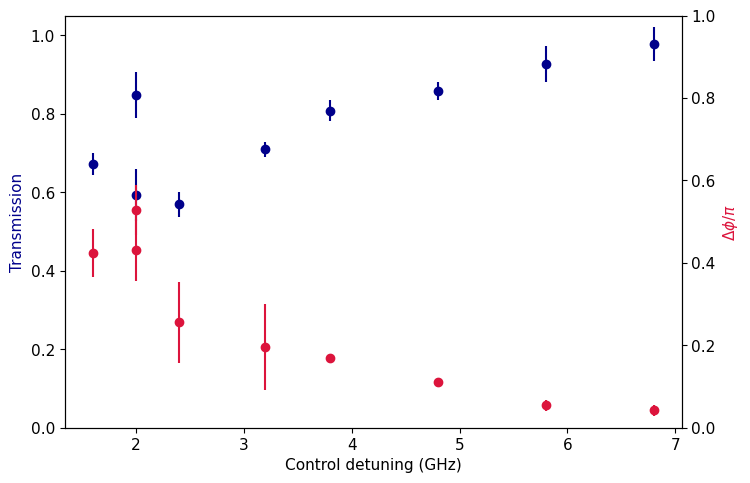

In [20]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

#arrays from the excel spreadsheet where we have the average transmission phase shift for different control detunings
#the two repeats are at different signal detunings with the same control detuning

TArray = [0.709, 0.848, 0.808, 0.927, 0.977, 0.857, 0.672, 0.593, 0.569]
TArrayError = [0.020, 0.058, 0.027, 0.046, 0.043, 0.023, 0.027, 0.067, 0.031]

DetuningArray = [3.2, 2, 3.8, 5.8, 6.8, 4.8, 1.6, 2, 2.4]
Phi1Array = [0.196, 0.528, 0.168, 0.054, 0.042, 0.110, 0.424, 0.431, 0.256]

Phi1ArrayError = [0.105, 0.060, 0.010, 0.014, 0.014, 0.010, 0.058, 0.075, 0.098]

ax1.scatter(DetuningArray, TArray, c='darkblue')
ax2.scatter(DetuningArray, Phi1Array, c='crimson')

ax1.errorbar(DetuningArray, TArray, yerr=TArrayError ,ls='none', ecolor='darkblue')
ax2.errorbar(DetuningArray, Phi1Array, yerr=Phi1ArrayError, ls='none', ecolor='crimson')

ax1.set_xlabel("Control detuning (GHz)")

ax2.set_ylabel("$\Delta \phi$/$\pi$", c='crimson')
ax1.set_ylabel('Transmission', c='darkblue')         

ax2.set_ylim(0,1)
ax1.set_ylim(0,1.05)       
         
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

#plt.title(label="Transmission and phase shift pulsed signal", fontsize=12,color="maroon")

fig.tight_layout() #makes the margins around the figure tight to the figure 

fig.set_figheight(5) #sets the size of the subplot figure
fig.set_figwidth(8)

plt.savefig('Phase changes and transmission for different control detunings.png', dpi=400, bbox_inches='tight')
plt.savefig('Phase changes and transmission for different control detunings.pdf', dpi=400, bbox_inches='tight')

plt.show()

#it looks like the re-taken data for 193.1698 THz that shows transmission over 1 has a much lower signal and control power
#reaching the detector than the for the older data at 193.1698 THz. Therefore I think we need to throw out the
#retaken with the dodgy transmission 

#the 193.1696 THz (2 GHz control detuning) shows a large phase shift and transmission than for 193.1698 THz 